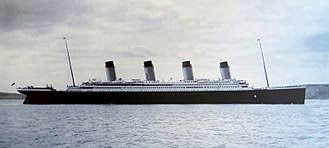
# Titanic Classification
## Story:
The sinking of the Titanic is one of history's greatest tragedies. Using basic information on the passengers and their survival rates I attempt to build a model that will predict whether or not each passenger survived for a kaggle competition. 

Disclaimer: Last semester I took a econometrics class where one student did a project using this dataset and econometrics to try and explain what had the biggest influence on whether or not certain people survived the Titanic. I don't remember the name of that student, but a lot of my ideas here are based off of his class presentation last December.

### Import Libraries:

In [1]:
import pandas as pd
import numpy as np
from fredapi import Fred
fred = Fred(api_key="7a9c02dcad776de16efb3eef1a2b293d")
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
import pprint
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
%matplotlib inline

## Data Cleaning
### Getting Data from CSV Files

In [49]:
train = pd.read_csv("C:\Stuff\kaggle_train.csv", low_memory=False)
train.drop(['PassengerId'], axis=1, inplace = True)
Pclass_train = train['Pclass']
Embarked_train = train['Embarked']
train_df = train
train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("C:\Stuff\kaggle_test.csv", low_memory=False)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Missing Data:
First I will create a function that will output the number of missing variables for each column.

From this it looks like the three columns with missing data are Age, Cabin, and Embarked in addition to a missing value in Fare in the testing dataset. I will go through each of these systematically to fix the missing data.

In [4]:
def missing_data():
    NA = train.columns[train.isnull().any()].tolist()
    return NA

train[missing_data()].isnull().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

In [5]:
def missing_data():
    NA = test.columns[test.isnull().any()].tolist()
    return NA

test[missing_data()].isnull().sum()

Age       86
Fare       1
Cabin    327
dtype: int64

### Age

There are 177 missing values for age in the training data. I decided that the best way for me to deal with these missing values was to find the mean age and replace them with that. 

In [6]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
train.loc[train['Age'].isnull(),'Age'] = 29.699118
test.loc[test['Age'].isnull(),'Age'] = 29.699118

### Cabin
Cabin has a lot of missing values in both the training and testing data. It looks like those people with missing values probably didn't have a cabin and the first letter of each cabin corresponds to the area of the ship the cabin was in. Thus I'm going to change the data a bit to only include the cabin location and then replace the missing vales with "Z" to suggest they didn't have a cabin. I'm doing this instead of simply dropping the data because there is a chance that where a passenger's cabin is located in the ship may influence whether they survived as I know from my middle school history class that one side of the ship sunk before the other. 

In [8]:
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'Z' for i in train['Cabin'] ])
test["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'Z' for i in test['Cabin'] ])
train['Cabin'].value_counts()

Z    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

### Embarked
There are only two missing variables in Embarked so I will replace these with the most common value. Embarked is the port that the passengers were embarked on. C = Cherbourg, Q = Queenstown, and S = Southhampton. Most people embarked from Southampton so I'll replace the missing values with S.

In [9]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
train.loc[train['Embarked'].isnull(),'Embarked'] = 'S'
test.loc[test['Embarked'].isnull(),'Embarked'] = 'S'

### Fare
There is only one missing value for Fare, I originally was going to just fill this with the average, but I saw that there is such a large std in comparison to the mean so I instead filled it with the median.


In [11]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [12]:
train['Fare'].median()

14.4542

In [13]:
train.loc[train['Fare'].isnull(),'Fare'] = 14.4542
test.loc[test['Fare'].isnull(),'Fare'] = 14.4542

## Manipulating Some of Our Data
Looks like ticket and name may be hard to deal with. Let's see what I can do to make our dataset more useful.

### Ticket
After looking through the data for ticket numbers, I decided to drop this column as I don't see a way to use ticket numbers in my predictive mode.

In [14]:
train.drop(['Ticket'], axis=1, inplace = True)
test.drop(['Ticket'], axis=1, inplace = True)

### Name 
I also have the name column. Because each name is unique, it's unlikely that this will help my model. However, most people in the model also have a title attached to their name which may have some correlation to their survival. For example, if someone has a big title they may have been more of a priority in getting off the boat. First I will separate the titles from the names. 

In [15]:
train_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(train_title)
train["Title"].head()


0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [16]:
test_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(test_title)


train.drop(['Name'], axis=1, inplace = True)
test.drop(['Name'], axis=1, inplace = True)

In [17]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Jonkheer          1
Lady              1
Ms                1
Mme               1
Sir               1
Don               1
Capt              1
Name: Title, dtype: int64

In [18]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64

Making a dummy variable for every title is going to difficult. Especially because there are a lot of titles in train and not in test. I saw a kernal on kaggle that fixed this by taking all of the names that only have 1 or 2 values and assigning them to another variable "rare." I think I'm going to try that for this and if there is a correlation I'll keep it. 

After googling some what Mme and Mlle online, I found the following: Mme = Mrs and Mlle = Miss and Ms = Miss so I will include all those togehter. 

In [19]:
train["Title"] = train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train["Title"] = train["Title"].replace('Mme', 'Mrs')
train["Title"] = train["Title"].replace(['Mlle', 'Ms'], 'Miss')

In [20]:
test["Title"] = test["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test["Title"] = test["Title"].replace('Mme', 'Mrs')
test["Title"] = test["Title"].replace(['Mlle', 'Ms'], 'Miss')

### Get Dummy Variables
A lot of the columns are categorical so I will go through and change them into dummies using the get_dummies.

In [21]:
train = pd.get_dummies(train, columns = ["Embarked"], prefix="Embarked")
test = pd.get_dummies(test, columns = ["Embarked"], prefix="Embarked")

In [22]:
train = pd.get_dummies(train, columns = ["Sex"])
test = pd.get_dummies(test, columns = ["Sex"])

In [23]:
train = pd.get_dummies(train, columns = ["Pclass"], prefix="Class")
test = pd.get_dummies(test, columns = ["Pclass"], prefix="Class")

In [24]:
train = pd.get_dummies(train, columns = ["Cabin"], prefix="Cabin")
test = pd.get_dummies(test, columns = ["Cabin"], prefix="Cabin")

In [25]:
train.columns.difference(test.columns)
train = train.drop("Cabin_T",axis=1)

In [26]:
train = pd.get_dummies(train, columns = ["Title"], prefix="Title")
test = pd.get_dummies(test, columns = ["Title"], prefix="Title")

In [27]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,...,Cabin_E,Cabin_F,Cabin_G,Cabin_Z,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,22.0,1,0,7.2500,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
1,1,38.0,1,0,71.2833,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0


Looks good to me! Let's now move on to data visualization.

## Data Visualization
I'm going to go through all of the data to get some more information that will come in handy when creating our model. Our dependent variable here is whether or not the passenger survived, so first I'd like to see the correlations of each variable with the heat map. 

Lets see the correlation of all our variables with a heat map. 

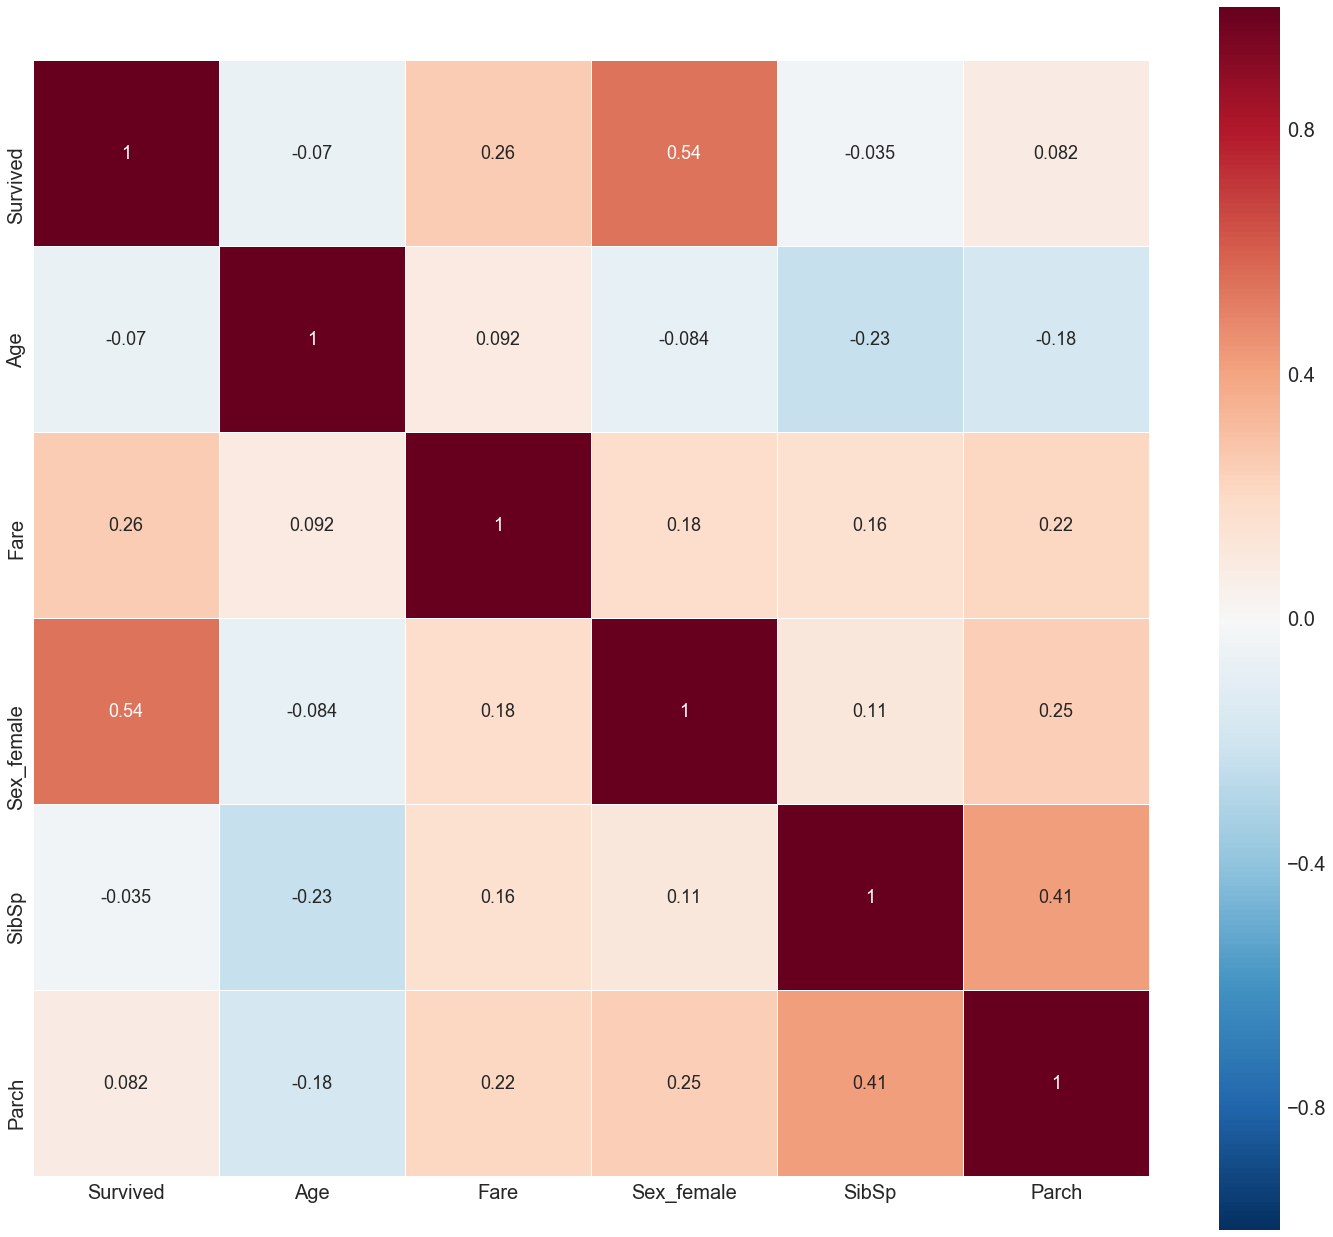

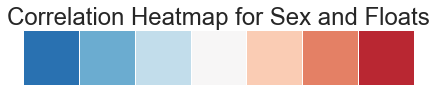

In [28]:
def heatmap(df):
    _ , ax = plt.subplots(figsize =(25, 25))
    colormap = sns.palplot(sns.color_palette("RdBu_r", 7))

    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':18 }
  

    )
sns.set(font_scale=2)

heatmap(train[['Survived', 'Age', 'Fare', 'Sex_female', 'SibSp', 'Parch']])
plt.title('Correlation Heatmap for Sex and Floats')

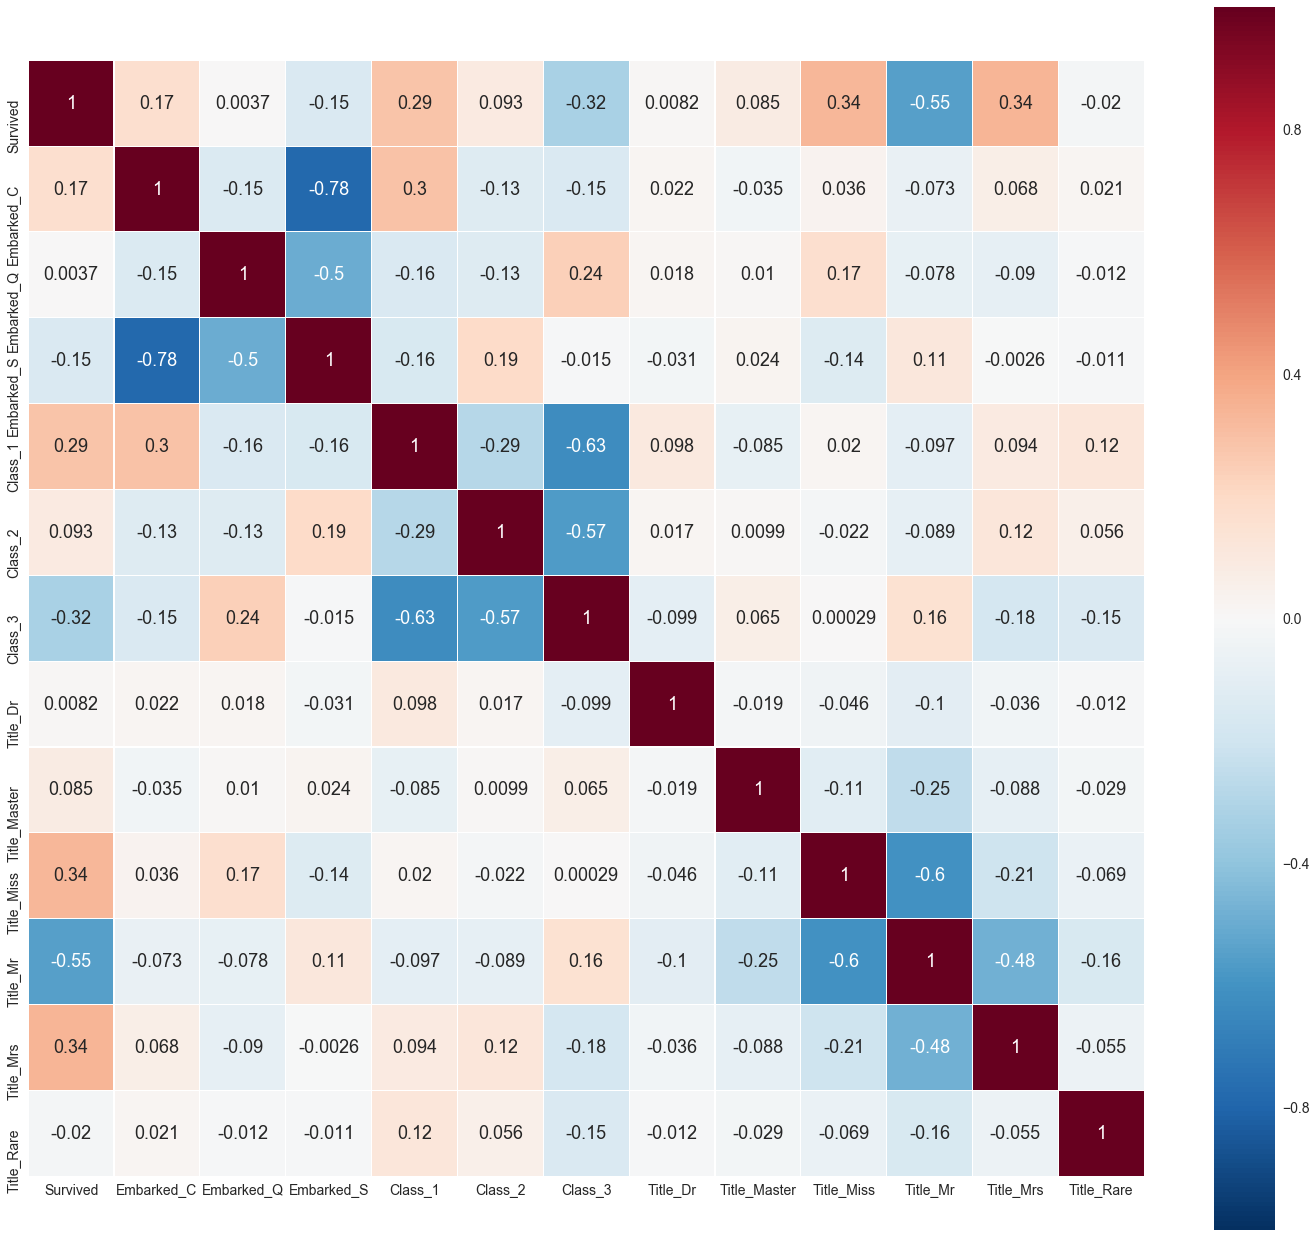

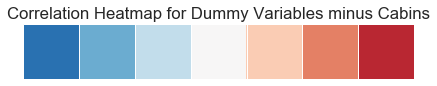

In [29]:
sns.set(font_scale=1.4)

h_train = train.drop(['Age', 'Fare', 'Sex_female', 'Sex_male', 'SibSp', 'Parch', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_Z'], axis=1)
heatmap(h_train)
plt.title('Correlation Heatmap for Dummy Variables minus Cabins')

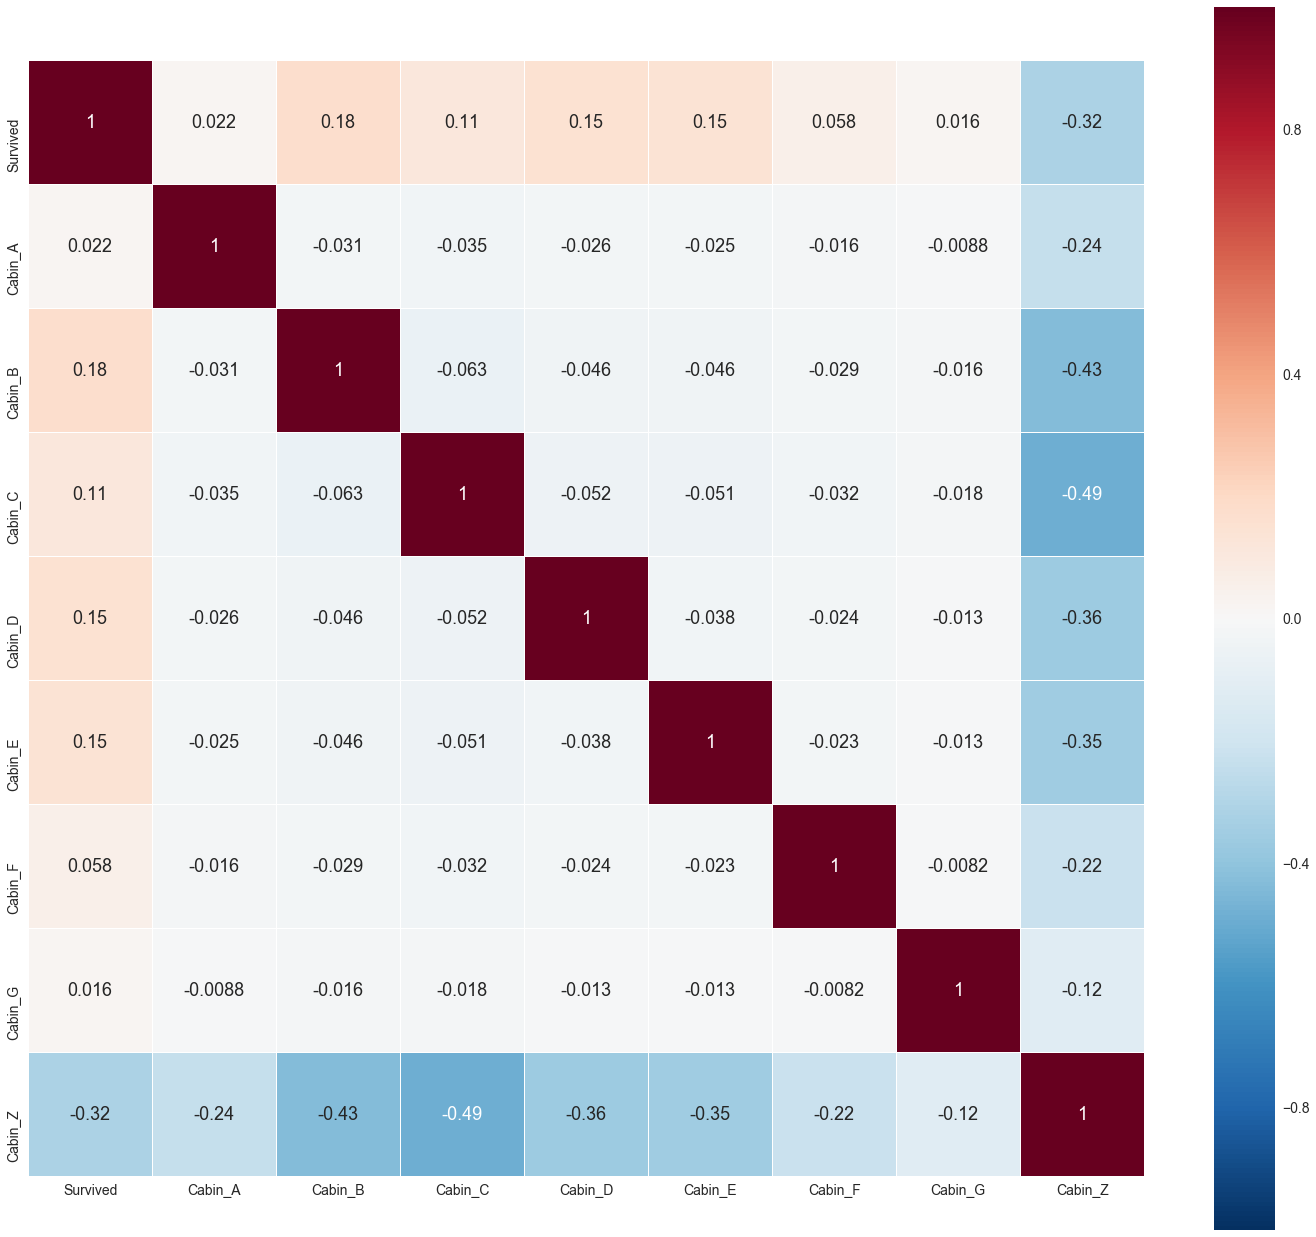

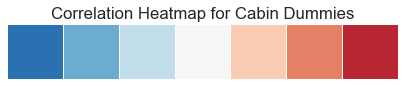

In [30]:
heatmap(train[['Survived','Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_Z']])
plt.title('Correlation Heatmap for Cabin Dummies')

Focusing on the survived column I find a few interesting correlations:
1. Age: Age has a small negative correlation with survival rate. 
2. Class: Correlation with survival increases as class increases from third to first class. This suggests that those in higher classes were more likely to survive. 
3. Sex: Females have a higher correlation to survival. 
4. Embarked: Those people who were meant to embark in Cherbourg had the highest correlation with survival than the other destinations followed by Queenstown.
5. Fare: Those who paid a higher fare had a higher correlation with survival.
6. SibSp: Those with siblings or spouses on board showed a slightly lower correlation to survival.
7. ParCh: Those with parents or children on board showed a slightly higher correlation to survival.
8. Your cabin doesn't seem to have much of a correlation to survival except for the fact that those who have them all have a higher correlation with survival, but those without a cabin seem a lot more likely to die than those who don't.

#### Age
Lets look a little more at age. First I'll plot a distribution of ages based on whether or not they survived:

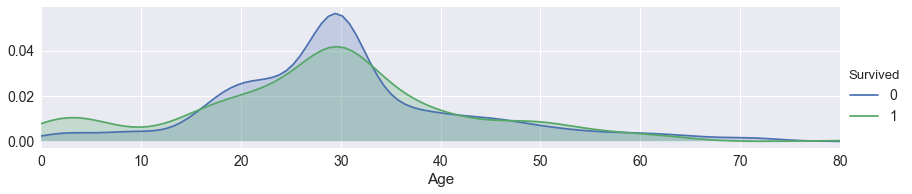

In [31]:
a = sns.FacetGrid(train, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train['Age'].max()))
a.add_legend()

Hmm. Looks like the age and survival rate is pretty evenly distributed with more people younger than 10 surviving. Let's check the correlation again:

In [32]:
train['Age'].corr(train['Survived'])

-0.069808516286241157

Age doesn't seem super correlated with survival but there is a slight negative trend as age increases which seems to reflect our distribution.
#### Class
I want to take another look at class. Based on our heatmap, it seems like as class increases, the chance of survival may also increase. 

In [33]:
pd.crosstab(train['Survived'], Pclass_train)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [34]:
Pclass_train.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Looks like there is a much larger number of people in lower classes that died over people in higher classes. Based on the training data 62% of first class survived compared to just 24% of third class and 47% of second class.  

### Embarked
Another variable that stood out a bit in the correlation maps was the embarked locations. Let's see a bar graph to see if we can understand it a little more. 

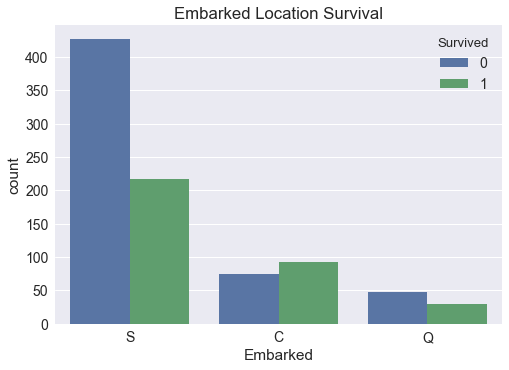

In [50]:
ax = sns.countplot('Embarked', hue='Survived',data = train_df)
ax.set_title('Embarked Location Survival')

Looks like those who embarked from Cherbourg were much more likely to survive as most of them in the training data did. 

# Modeling
I decided to do K-Nearest Neighbors, Random Forests, and SVM for my models. I chose these primarily because I understand those models the most. I also tried some gradient and ada boosting but due to some issues with my computer, I wasn't able to get it to work. 
### Get my training and testing sets

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, train['Survived'], test_size=0.2, random_state=42)

## Models: 
The following is the overview of each of my models. After creating the models I tested them based on accuracy, recall, percision, and F1. 

### K-Nearest Neighbors
This is a super easy algorithm for classification. Basically it goes like this
1. Define k
2. Define a distance metric - usually Euclidean distance
3. For a new data point, find the k nearest training points and combine their classes in some way - usually voting - to get a predicted class

K is the hyperparameter here. For my k, I kept increasing it until my score for the model went down. I stopped at 7 which I thought was pretty good because 7 is an odd number so the model won't be tied. 

In [36]:
from sklearn.neighbors import KNeighborsClassifier
k = KNeighborsClassifier(n_neighbors = 7)
k.fit(X_train, y_train)
Y_pred = k.predict(X_test)
k.score(X_test, y_test)

0.78212290502793291

In [37]:
f1_score(y_test, Y_pred)

0.70676691729323293

In [38]:
recall_score(y_test, Y_pred)

0.63513513513513509

In [39]:
precision_score(y_test, Y_pred)

0.79661016949152541

### Random Forests
Random forests trains a bunch of decision trees adn then ensambles them together so they all have a vote on the classification. It's great for creating a model with lower variance than a single tree. I chose to make 100 trees because it was at that time that the score for my model stopped increasing. Also I did a max_depth of 2 to avoid overfitting as that can be common with Random Forests. 

In [40]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=2)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, y_test)

1.0

In [41]:
f1_score(y_test, Y_pred)

1.0

In [42]:
recall_score(y_test, Y_pred)

1.0

In [43]:
precision_score(y_test, Y_pred)

1.0

### SVM
SVM stands for Support Vector Machine which uses learning methods for classification by creating a hyperplaine to categorize the data into those who survive and and those who did not. 
For this I just kept my hyper-paremeter C as the default 1 because a higher c will cause higher variance while a smaller would likely cause a higher bias. I played around a little with C but overall I found that a C of 1 provided the best results. 

In [44]:
from sklearn.svm import SVC, LinearSVC
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
svc.score(X_train, y_train)

0.9592696629213483

In [45]:
f1_score(y_test, Y_pred)

0.79729729729729737

In [46]:
recall_score(y_test, Y_pred)

0.79729729729729726

In [47]:
precision_score(y_test, Y_pred)

0.79729729729729726

## Results:

First I want to provide a little information on the scoring of each model. The following illustrates the formulas for Accuracy, Recall, Precision, and F1.

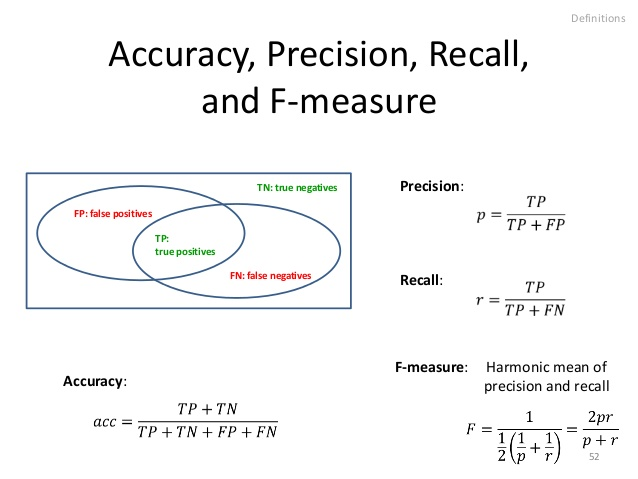

1. K-Nearest Neighbors
        - Accuracy score: 0.78212290502793291
        - Recall score: 0.63513513513513509
        - Precision score: 0.79661016949152541
        - F1 score: 0.70676691729323293
2. Random Forests
        - Accuracy score: 0.91061452513966479
        - Recall score: 0.83783783783783783
        - Precision score: 0.93939393939393945
        - F1 score: 0.88571428571428579
3. SVM
        - Accuracy score: 0.9592696629213483
        - Recall score: 0.79729729729729737
        - Precision score: 0.79729729729729737
        - F1 score: 0.79729729729729737
        
SVM has the highest accuracy score, but Random Forests has a higher recall, precision, and F1 score. Because of this, I will go with Random Forests to use on my test data. This model isn't perfect but it should prove to be fairly precise and accurate in predicting survival. This model does the poorest on recall, but in this case I would rather have a false negative than a false positive as it could be bad to predict survival when they really died. For that reason, I believe the random forest model which shows the highest precision score out of all the other models is the best one to go with. 

In [48]:
testing_fit = random_forest.predict(test)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": testing_fit
    })
submission.to_csv('Final.csv', index=False)